In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import get_ECT_regression, HUEOrder, get_pi_matrix, clean_numerical_data, MyCounter

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import plotly.subplots as plsp
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from collections import Counter

pd.set_option('display.max_columns', None)
plt.rc('font',family = 'serif')
plt.rc('axes', axisbelow=True)

path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

sstyle = 'seaborn-v0_8-poster'
plt.style.use(sstyle)


In [3]:
# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")
min_subset_ids_joe  = pd.read_csv(path+"deviation_id.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical TOKAMAKS
#DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = "Decreasing"

DB5.insert(loc=2,column="label_9998",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = "Decreasing"

DB5.insert(loc=2,column="label_joe",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_joe.id)].index), "label_joe"] = "Decreasing"

DB5.insert(loc=2,column="Spherical",value=["False"]*len(DB5))
DB5.loc[(DB5[DB5.TOK.isin(['START','MAST','NSTX'])].index), "Spherical"] = "True"

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
    "\n\n\n  Subset given by Joseph Hall           \n--------\n" +
    f"{ round( (len(min_subset_ids_joe)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_joe)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

  Subset that decrease alpha-R to 0.6357
--------
23.45% affected alpha_R
76.55% did not affect alpha_R


  Subset that decrease alpha-R to 0.9998
--------
9.88% affected alpha_R
90.12% did not affect alpha_R


  Subset given by Joseph Hall           
--------
18.46% affected alpha_R
81.54% did not affect alpha_R


In [4]:
DB5 = tokamakTK.clean_categorical_data(DB5)
# Needed for Improved Visualization: 2D and 3D Plots
HUE_ORDER, PX_ORDER = tokamakTK.get_colors_per_category(DB5)
hue_order = HUEOrder(HUE_ORDER)

# ---------------------------------------------------

# SPECIAL PARAMETERS
colors_ = sns.color_palette('tab20', 20)
HUE_ORDER["Spherical"] = dict(zip(sorted(DB5["Spherical"].unique()), colors_[:len(DB5["Spherical"].unique())]))
HUE_ORDER["label_joe"] = dict(zip(sorted(DB5["label_joe"].unique()), colors_[:len(DB5["label_joe"].unique())]))

In [5]:
# alpha_R -- 0.6358 --> when considering DB2 for calculation
data1 = DB5[DB5.label_6357.isin(["Decreasing"])].reset_index(drop=True)

# alpha_R -- 2.1560 --> when considering DB2 for calculation
data2 = DB5[DB5.label_6357.isin(["Unaffected"])].reset_index(drop=True)

# Removing DB2, because most of these shots have missing info
#data2 = data2[~data2.id.isin(DB2.id.values)].reset_index(drop=True)

data = [data1, data2]

In [6]:
def get_NUSTAR_info(variable, parameter, y_label,  ymin=None, ymax=None):   
    # Create a figure with twimport matplotlib.pyplot as plt

import numpy as npo subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.7))

    # Set the parameter and category colors
    category_colors = HUE_ORDER[parameter]
    xmin, xmax = (-0.1, 3)
    ymin, ymax = (ymin, ymax)

    x_label = "Normalized Ion Collision Frequency"
    
    # Plot data1 in the first subplot (ax1)
    data1["colors"] = data1[parameter].map(category_colors)
    data2["colors"] = data2[parameter].map(category_colors)

    ax1.scatter(data1["NUSTAR"], data1[variable], color=data1["colors"].values, edgecolors='white', s=90)
    ax1.set_ylabel(y_label, fontsize=17)
    ax1.grid(alpha=0.5)

    # Plot data2 in the second subplot (ax2)
    ax2.scatter(data2["NUSTAR"], data2[variable], color=data2["colors"].values, edgecolors='white', s=90)

    # Add a legend to the first subplot
    legend_elements = []
    for category, color in category_colors.items():
        legend_elements.append(plt.Line2D([0], [0], marker='o', 
                                          color='w', label=category, markerfacecolor=color, markersize=9))
    legend = ax2.legend(handles=legend_elements, frameon=False, loc='upper right', 
                        bbox_to_anchor=(1.4, 1.05), fontsize=13)
    ax2.grid(alpha=0.5)

    ax1.set_xlim(xmin, xmax)
    ax2.set_xlim(xmin, xmax)

    ax1.set_ylim(ymin, ymax)
    ax2.set_ylim(ymin, ymax)

min_subset_ids_6357
    ax1.set_title("Decreasing\n")
    ax2.set_title("Unaffected\n")

    fig.text(0.5, -0.05, x_label, ha='center', fontsize=17)


    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()


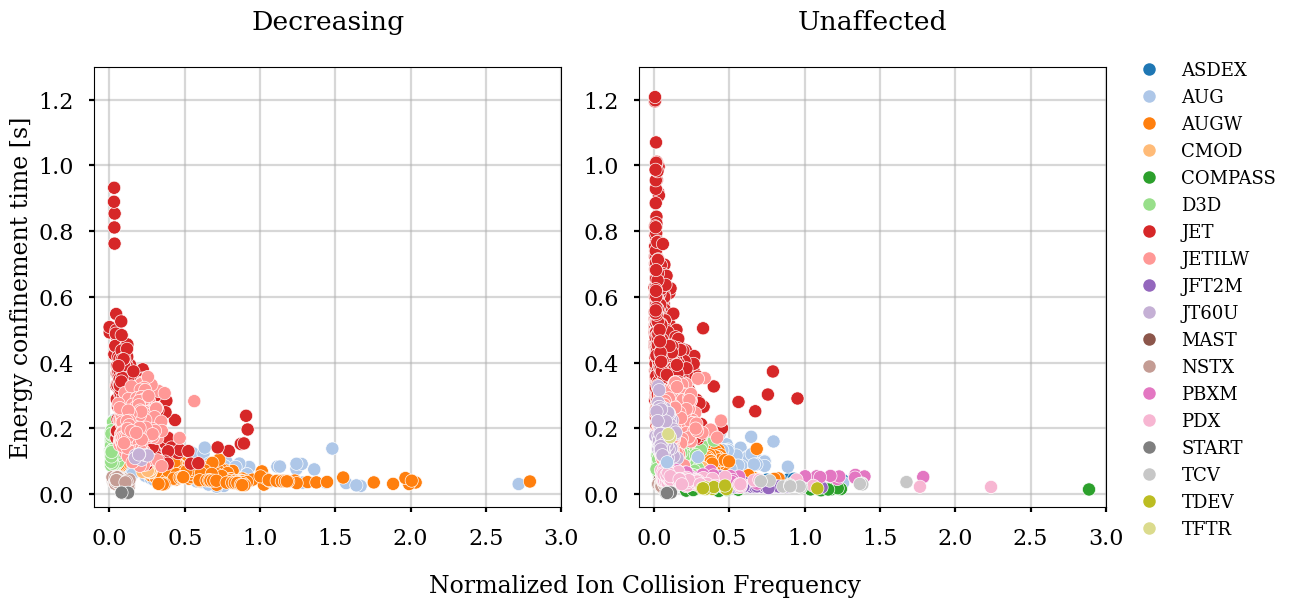

In [7]:
get_NUSTAR_info("TAUTH", "TOK", "Energy confinement time [s]",  ymin=-0.04, ymax=1.3)

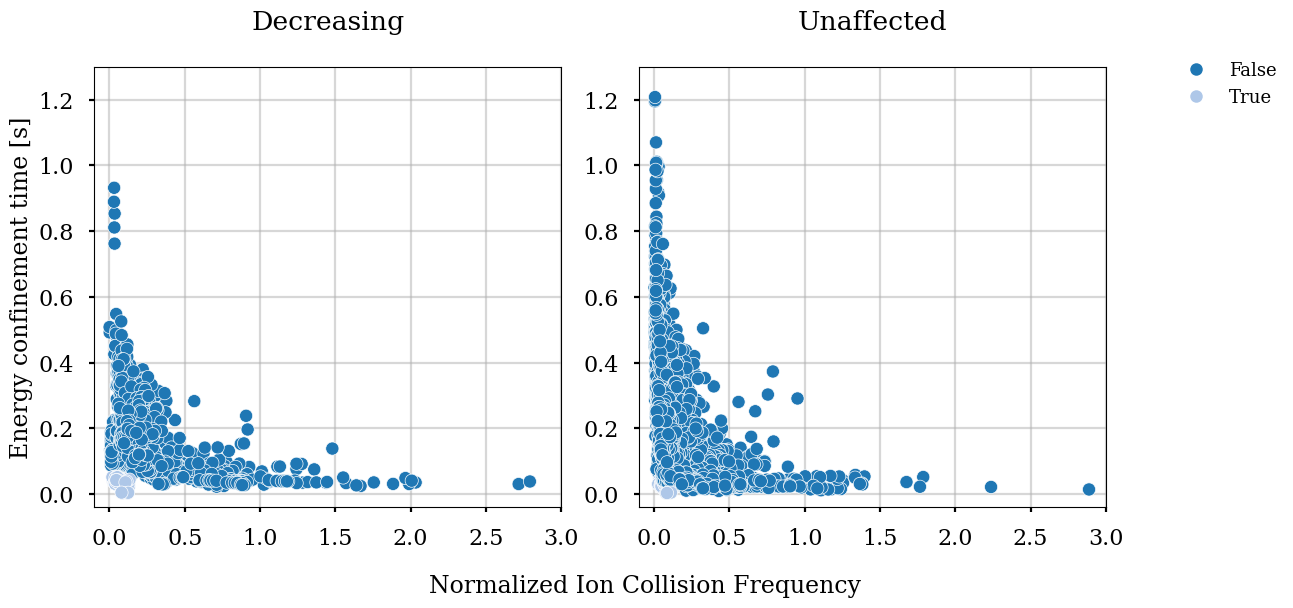

In [8]:
get_NUSTAR_info("TAUTH", "Spherical", "Energy confinement time [s]",  ymin=-0.04, ymax=1.3)

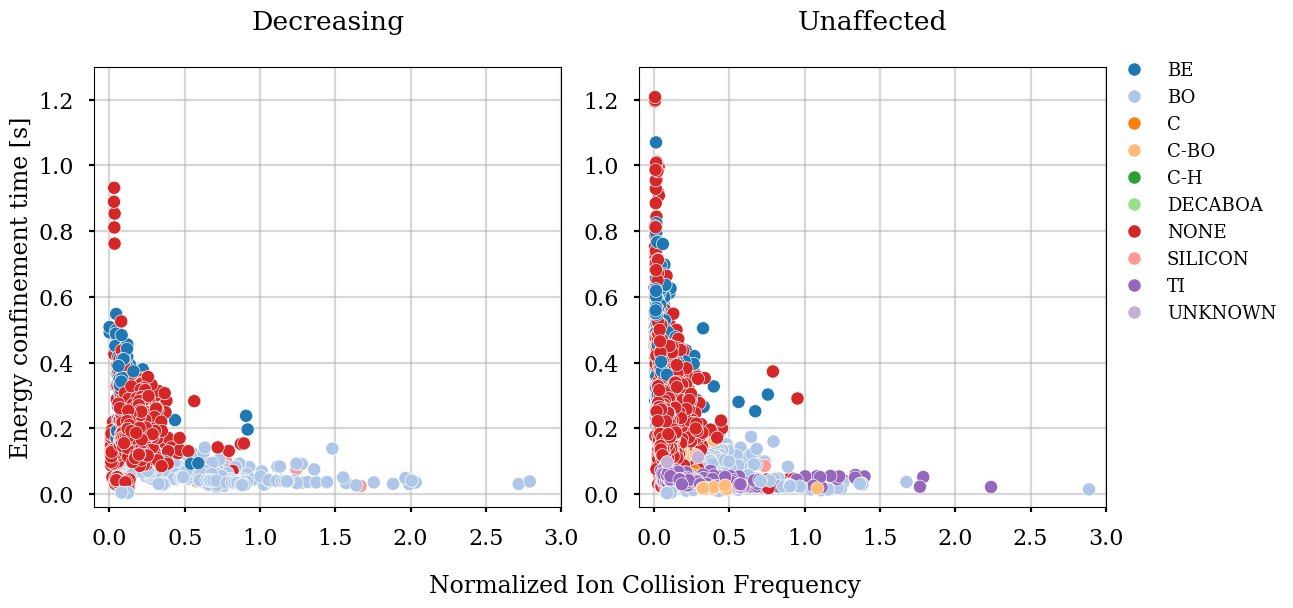

In [9]:
get_NUSTAR_info("TAUTH", "EVAP", "Energy confinement time [s]",  ymin=-0.04, ymax=1.3)

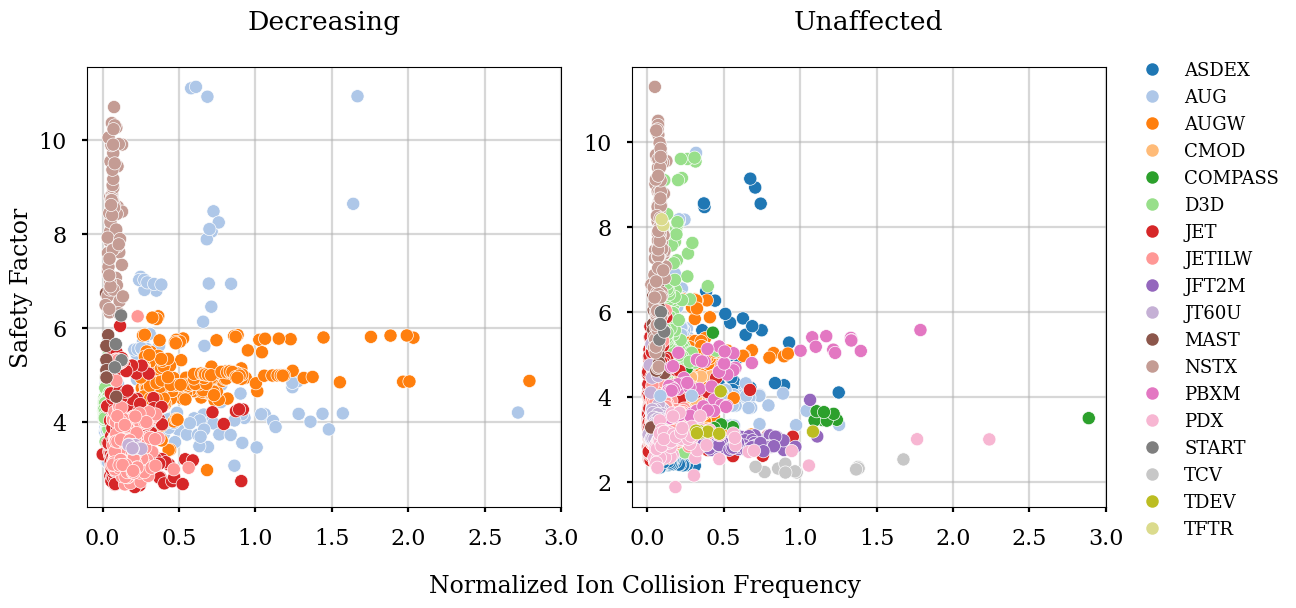

In [10]:
get_NUSTAR_info("Q95", "TOK", "Safety Factor",  ymin=None, ymax=None)

In [11]:
px.scatter_3d(
              data_frame=DB5, x="NUSTAR", y="TAV", z="Q95", 
              color="Spherical", color_discrete_map={"True":"red","False":"black"}
             )

In [14]:
px.scatter_3d(
              data_frame=DB5, x="NUSTAR", y="RHOSTAR", z="TAUTH", 
              color="label_6357", color_discrete_map={"Decreasing":"red","Unaffected":"black"}
             )

In [175]:
def get_3D_plot_DB5(db5, indxs, saveFig=False, file_name=""):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    alpha = round(
        get_ECT_regression(
            DB5[DB5.id.isin(DB2.id.values) | DB5.id.isin(indxs.id.values)]
        ).params["RGEO"], 2
    )
    
    data = db5.copy()
    x, y, z = "NUSTAR", "RHOSTAR", "BETASTAR"
    
    # Plot the data points with color based on "TAUTH"
    scatter = ax.scatter(data[x], data[y], data[z], c=data["TAUTH"], 
                         cmap="CMRmap")
    ax.set_xlabel(x, fontsize=14, labelpad=14)
    ax.set_ylabel("\n\n"+y, fontsize=14, labelpad=27)
    ax.set_zlabel(z, fontsize=14, labelpad=11,  rotation=90)  
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.tick_params(axis='z', labelsize=13)
    
    #ax.set_title("STDB5 without Spherical Tokamaks")
    
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticks(), rotation=45)
    
    # Add a color bar
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.65, aspect=27, pad=0.03)
    cbar.set_label("\nEnergy Conginement Time [s]", fontsize=17)
    cbar.ax.tick_params(labelsize=13)

    
    ax.view_init(elev=23, azim=220)
    
    if saveFig:
        plt.savefig(path + file_name)
        #plt.savefig(path + file_name, format="png", dpi=800)


In [176]:
"""get_3D_plot_DB5(DB5, min_subset_ids_6357, saveFig=True, 
                file_name=fig_path+"3D_plot_TAUTH_RNB_STDB5.pdf")""";

In [177]:
"""get_3D_plot_DB5(DB5[DB5.Spherical.isin(["False"])], min_subset_ids_6357, saveFig=True, 
                file_name=fig_path+"3D_plot_TAUTH_RNB_STDB5_noSPHR.pdf")""";

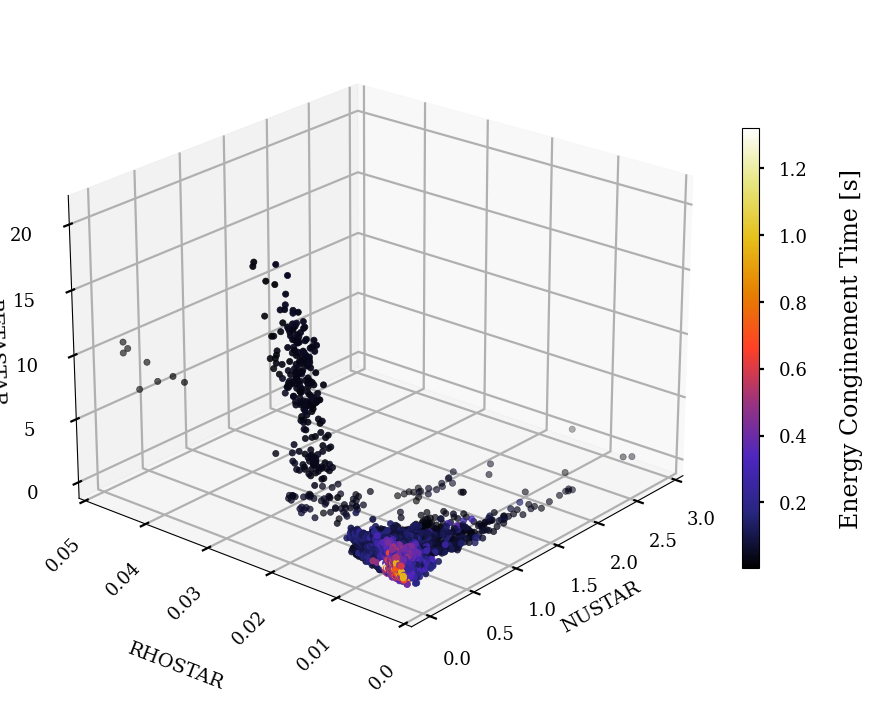

In [178]:
get_3D_plot_DB5(DB5, min_subset_ids_6357)

In [184]:
#round(get_ECT_regression(DB5[DB5.id.isin(min_subset_ids_6357.id.values) | DB5.id.isin(DB2.id.values)]).params, 3)

const   -2.260
IP       1.422
BT       0.020
NEL     -0.136
PLTH    -0.529
RGEO     0.636
KAREA   -0.002
EPS     -0.557
MEFF     0.130
dtype: float64

In [193]:
round(get_ECT_regression(DB5[~DB5.id.isin(min_subset_ids_9998.id.values)]).params, 3)

const   -2.555
IP       1.007
BT       0.119
NEL      0.265
PLTH    -0.706
RGEO     1.709
KAREA    0.340
EPS      0.324
MEFF     0.231
dtype: float64

In [186]:
get_ECT_regression(DB5[DB5.id.isin(min_subset_ids_9998.id.values) | DB5.id.isin(DB2.id.values)]).params

const   -2.296352
IP       1.237057
BT       0.109940
NEL     -0.020315
PLTH    -0.568605
RGEO     0.999819
KAREA    0.142320
EPS     -0.187247
MEFF     0.123010
dtype: float64

In [192]:
np.exp(-2.555272)

0.07767110265391056